# Imports

In [2]:
# Basic imports
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Plotting and animations
import cartopy 
import cartopy.crs as ccrs
import math
import ipywidgets as widgets
import datetime
from IPython.display import HTML
from matplotlib import animation
from typing import Optional

# Model
from UNet import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Reshape

In [3]:
def plot_state(state, prediction=None, target=None):
    add = 0
    if prediction is not None:
        add += 1
    if target is not None:
        add += 1
    fig, ax = plt.subplots(1, state.shape[0] + add, figsize=(20, 5))
    for i in range(state.shape[0]):
        ax[i].imshow(state[i])
        ax[i].set_title(f'Input {i}')
        plt.colorbar(ax[i].imshow(state[i]), ax=ax[i])

    if prediction is not None:
        ax[state.shape[0]].imshow(prediction)
        ax[state.shape[0]].set_title('Prediction')
        plt.colorbar(ax[state.shape[0]].imshow(prediction), ax=ax[state.shape[0]])
                     
    if target is not None:
        ax[state.shape[0] + 1 - add].imshow(target)
        ax[state.shape[0] + 1 - add].set_title('Target')
        plt.colorbar(ax[state.shape[0] + 1- add].imshow(target), ax=ax[state.shape[0] + 1 - add])

    plt.show()

In [4]:
ds = xr.open_dataset('ERA5_Data\WindComponents.nc')
# ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))
ds.load()

ds['ws'] = (ds.u10**2 + ds.v10**2)**0.5

c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [5]:
window_size = 3
variable = 'ws'

X, y = [], []

for i in range(ds.time.size - window_size):
    X.append(ds[variable].isel(time=slice(i, i + window_size)))
    y.append(ds[variable].isel(time=i + window_size))

X_ = np.array(X) 
y_ = np.array(y)

features = X_[0]
target = y_[0]

# ax, fig = plt.subplots(1, window_size + 1, figsize=(20, 5))
# for i in range(window_size):
#     fig[i].imshow(features[i])
#     fig[i].set_title(f'Input {i}')
#     plt.colorbar(fig[i].imshow(features[i]), ax=fig[i])

# fig[window_size].imshow(target)
# fig[window_size].set_title('Target')
# plt.colorbar(fig[window_size].imshow(target), ax=fig[window_size])
# plt.show()

# Train Validation Split
input_shape = X_.shape[1:]
split = round(X_.shape[0] * 0.9)

# Shape fixing
lon_shape = 30 
# X_ = X_[:,:,:, :70]
# y_ = y_[:,:,:70]

# Normalization
max_ws = X_.max()
X_n = X_ / max_ws
y_n = y_ / max_ws

# f_train_plot, t_train_plot = X_n[:split].astype('float32'), y_n[:split].astype('float32')
# f_test_plot, t_test_plot = X_n[split:].astype('float32'), y_n[split:].astype('float32')

f_train, t_train = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_test, t_test = X_n[split:].astype('float32'), y_n[split:].astype('float32')
print('Train Shape: ', f_train.shape, t_train.shape, '\n\nTest Shape: ', f_test.shape, t_test.shape)

X_n = X_n.reshape(-1, ds.latitude.size, lon_shape, window_size)
y_n = y_n.reshape(-1, ds.latitude.size, lon_shape,  1)

f_training, t_training = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_testing, t_testing = X_n[split:].astype('float32'), y_n[split:].astype('float32')

Train Shape:  (625, 3, 10, 30) (625, 10, 30) 

Test Shape:  (69, 3, 10, 30) (69, 10, 30)


# Build Model

In [6]:
def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 16)
    s2, p2 = encoder_block(p1, 32)
    # s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p2, 64) #Bridge

    # d1 = decoder_block(b1, s4, 512)
    # d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 32)
    d4 = decoder_block(b1, s2, 16)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  
    
    model = Model(inputs, outputs, name="U-Net")
    return model

In [7]:
input_shape = tuple((1, ds.latitude.size, ds.longitude.size, window_size))
plot_shape = t_training[0].shape
output_shape = t_train.shape[1:] 

kernel_size = (1, 3)
pool_size = (2,2)
model = build_unet(input_shape[1:])
model.summary()  

print(model.predict(f_train[0:1].reshape(input_shape)).shape)  



Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 30, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 10, 30, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 10, 30, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 10, 30, 64)           0         ['batch_normalization[0]

In [8]:
batch_size = 128
epochs = 500
model.compile(optimizer='adam', loss='mse')

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model_synth.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')

if True:
    history = model.fit(
        f_training, 
        t_training, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=1, 
        validation_data=(f_testing, t_testing),
        callbacks=[early_stopping, model_checkpoint]
    )

else:
    model.load_weights('best_model_colab.h5')

Epoch 1/500

5/5 [==============================] - ETA: 0s - loss: 0.0675
Epoch 1: val_loss improved from inf to 0.03279, saving model to best_model_synth.h5
5/5 [==============================] - 14s 3s/step - loss: 0.0675 - val_loss: 0.0328


c:\Users\23603526\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/500
5/5 [==============================] - ETA: 0s - loss: 0.0199
Epoch 2: val_loss improved from 0.03279 to 0.03215, saving model to best_model_synth.h5
5/5 [==============================] - 15s 3s/step - loss: 0.0199 - val_loss: 0.0322
Epoch 3/500
5/5 [==============================] - ETA: 0s - loss: 0.0142
Epoch 3: val_loss did not improve from 0.03215
5/5 [==============================] - 14s 3s/step - loss: 0.0142 - val_loss: 0.0326
Epoch 4/500
1/5 [=====>........................] - ETA: 11s - loss: 0.0126

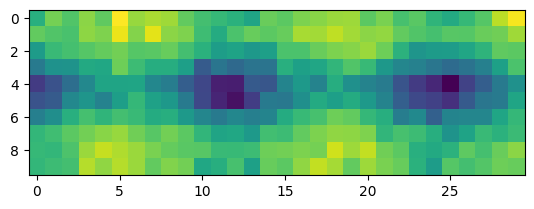

In [ ]:
plt.imshow(t_test[1])

1/1 [==============================] - 0s 33ms/step


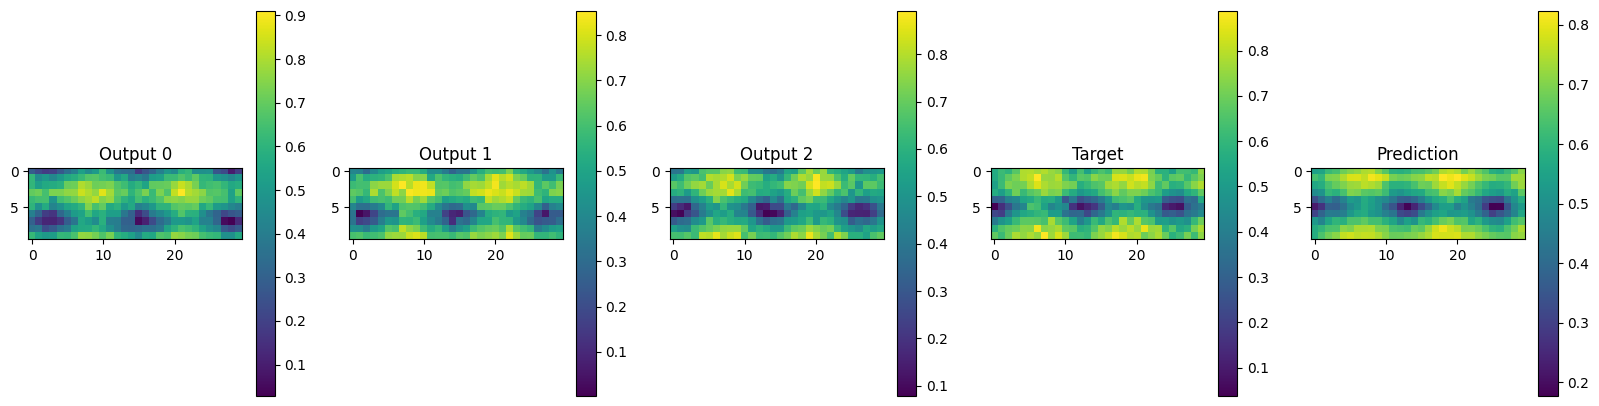

1/1 [==============================] - 0s 27ms/step


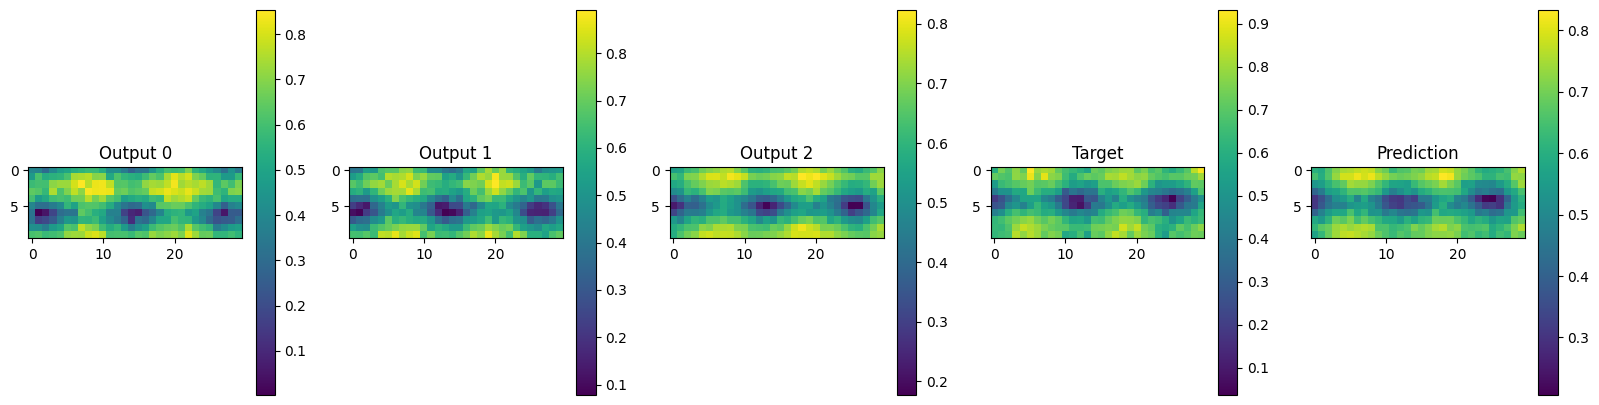

1/1 [==============================] - 0s 28ms/step


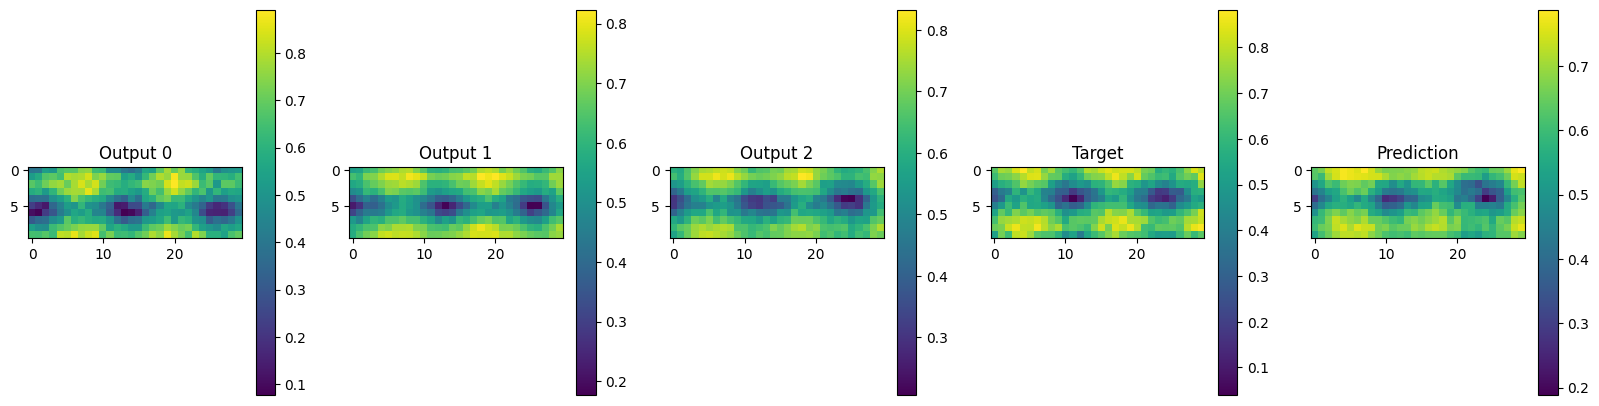

1/1 [==============================] - 0s 30ms/step


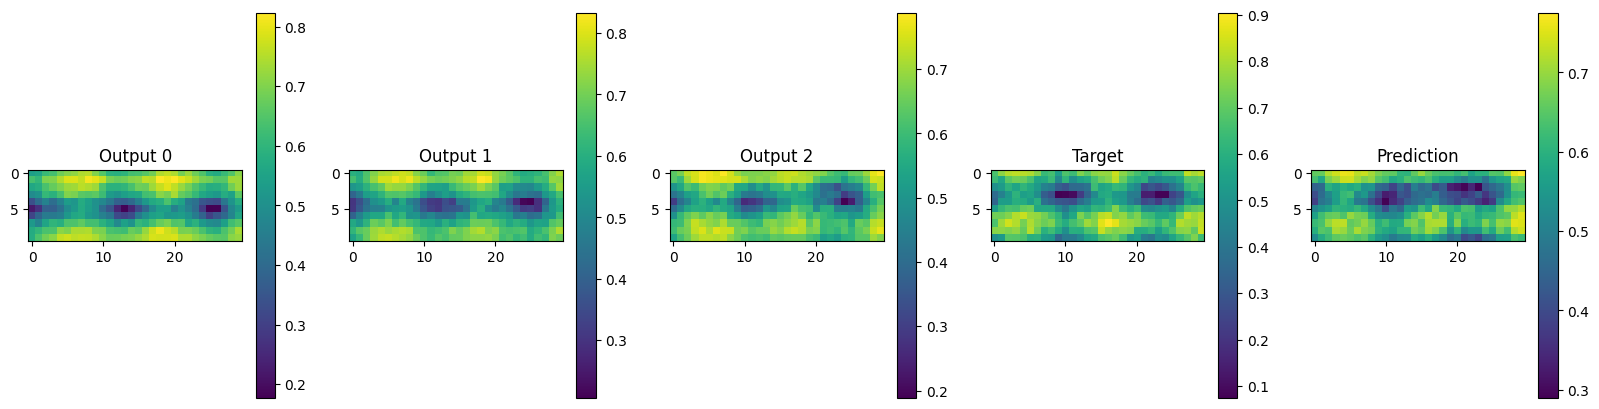

1/1 [==============================] - 0s 22ms/step


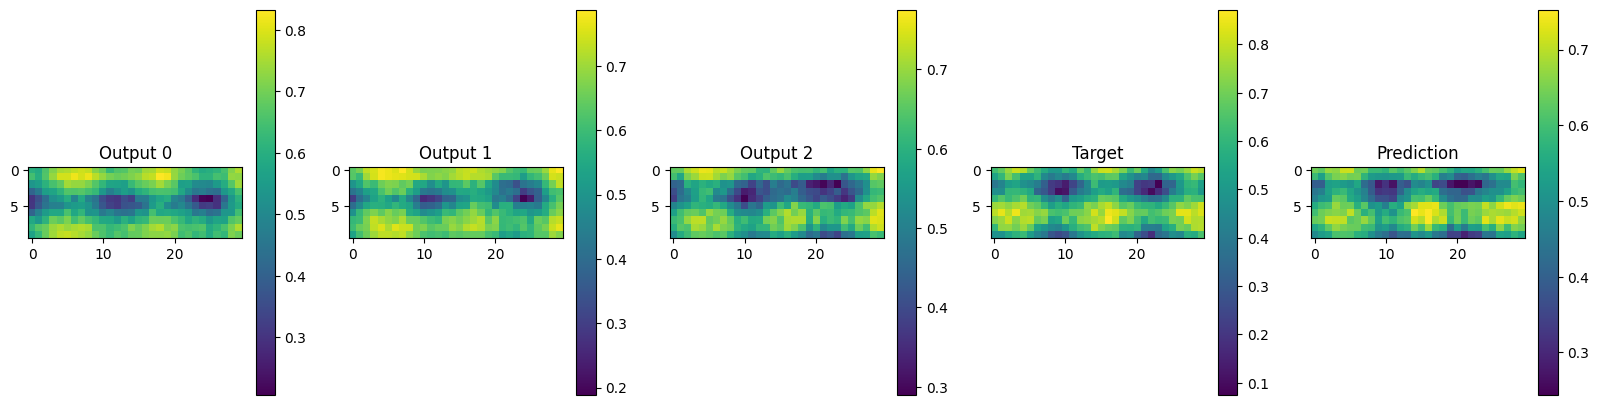

1/1 [==============================] - 0s 41ms/step


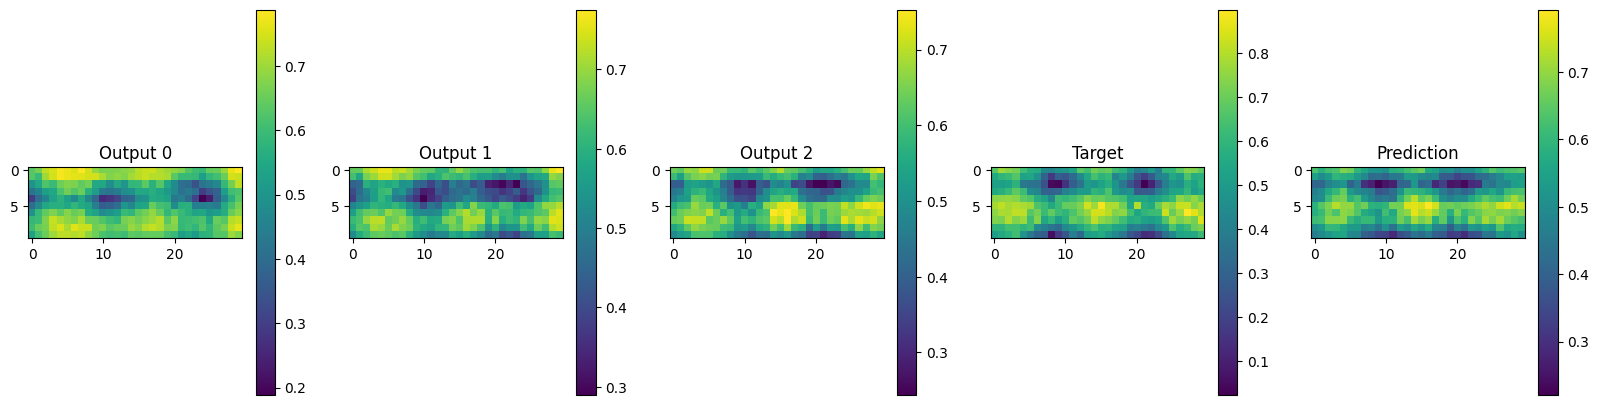

1/1 [==============================] - 0s 26ms/step


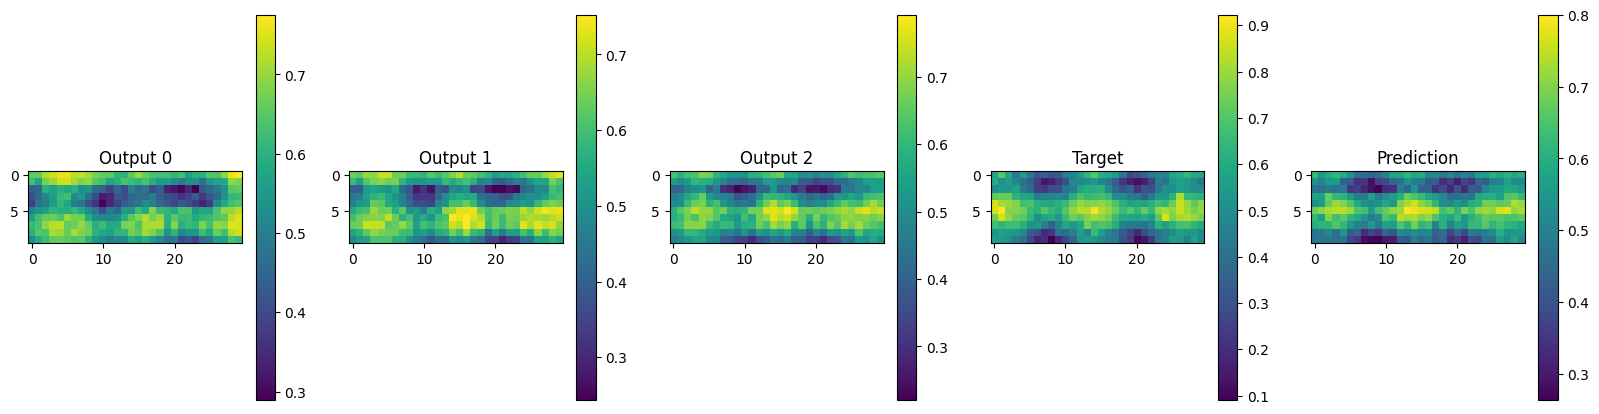

1/1 [==============================] - 0s 41ms/step


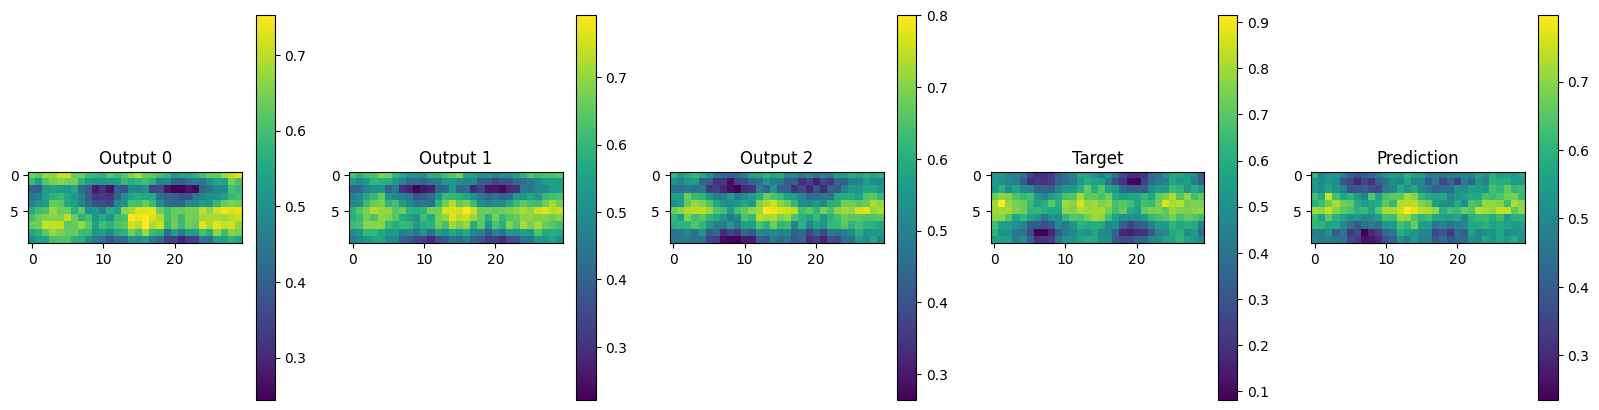

1/1 [==============================] - 0s 25ms/step


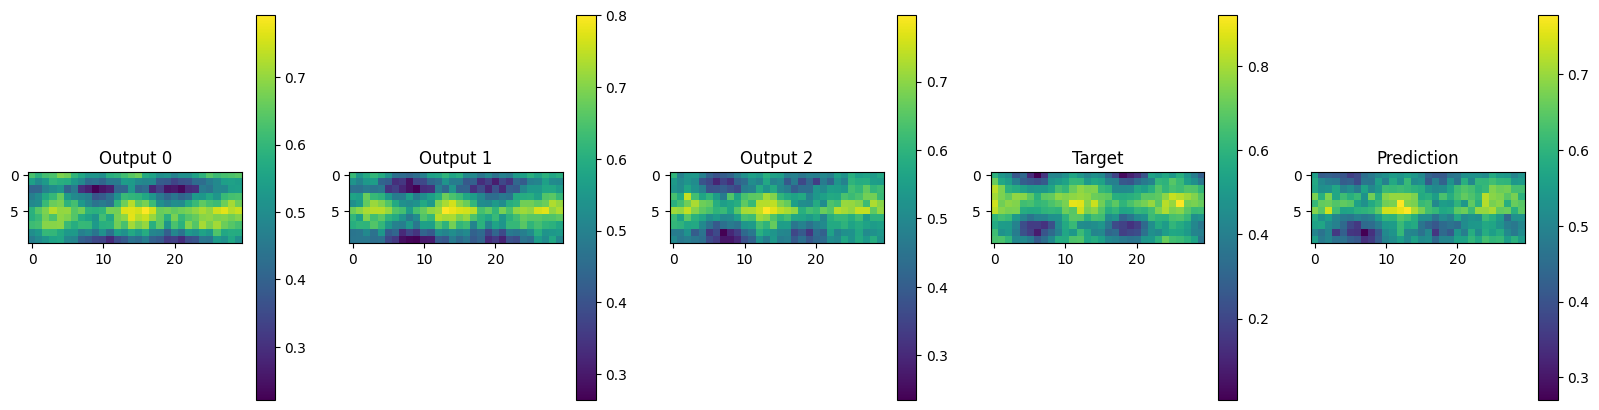

1/1 [==============================] - 0s 17ms/step


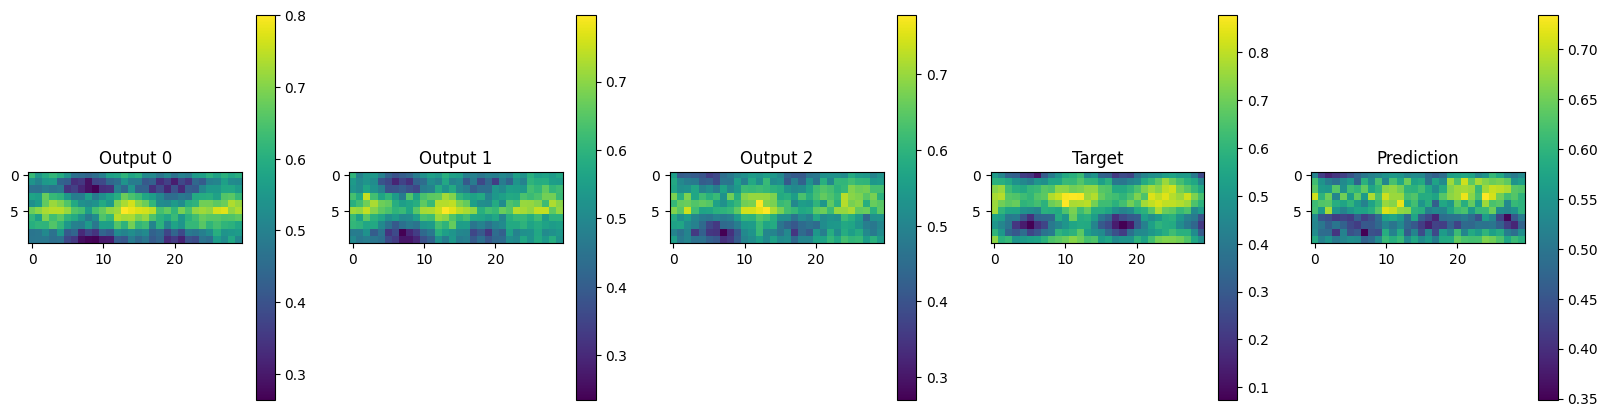

1/1 [==============================] - 0s 27ms/step


In [ ]:
model.load_weights('models/best_model_synth.h5')

current_state = f_test[0:1]

pred = model.predict(current_state.reshape(input_shape)).reshape(plot_shape)

for i in range(10):
    plot_state(current_state, prediction=pred, target=t_test[i])
    current_state = current_state[:,1:]
    current_state = np.append(current_state, pred.reshape(1, 1, pred.shape[0], pred.shape[1]), axis=1)

    pred = model.predict(current_state.reshape(input_shape)).reshape(plot_shape)

